In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF,WhiteKernel,DotProduct
import pandas as pd
import torch



In [2]:
from snorkel import SnorkelSession
from snorkel.models import candidate_subclass
from snorkel.annotations import load_gold_labels
from snorkel.learning.pytorch import LSTM
from snorkel.annotations import load_marginals

from scipy import vstack
session = SnorkelSession()

In [3]:
ChemicalDisease = candidate_subclass('ChemicalDisease', ['chemical', 'disease'])

train = session.query(ChemicalDisease).filter(ChemicalDisease.split == 0).all()
dev = session.query(ChemicalDisease).filter(ChemicalDisease.split == 1).all()
test = session.query(ChemicalDisease).filter(ChemicalDisease.split == 2).all()

print('Training set:\t{0} candidates'.format(len(train)))
print('Dev set:\t{0} candidates'.format(len(dev)))
print('Test set:\t{0} candidates'.format(len(test)))

Training set:	8433 candidates
Dev set:	920 candidates
Test set:	4683 candidates


In [4]:
train_marginals = load_marginals(session, split=0)

In [5]:
from load_external_annotations import load_external_labels
load_external_labels(session, ChemicalDisease, split=2, annotator='gold')
L_gold_test = load_gold_labels(session, annotator_name='gold', split=2)
L_gold_dev = load_gold_labels(session,annotator_name='gold',split=1)

AnnotatorLabels created: 0


In [6]:
L_gold_dev.shape

(920, 1)

In [7]:
dev_labels = L_gold_dev.toarray().reshape(920,)
dev_labels[dev_labels == -1] = 0

In [8]:
full_train_set = train.copy()
full_train_set.extend(dev)
full_train_labels = list(train_marginals).copy()
full_train_labels.extend(dev_labels)
full_train_labels = np.array(full_train_labels)


In [9]:
lstm = LSTM(n_threads=None)

lstm.load('trained_on_all')

[LSTM] Loaded model <trained_on_all>


In [10]:
lstm.score(test, L_gold_test)

/home/cperreault/anaconda3/envs/snorkel-extraction/lib/python3.6/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


(0.40493910690121787, 0.79062087186261554, 0.53557046979865774)

In [11]:
# am I reshaping correctly?
dev_features = lstm.feature_outputs(dev, 100).detach().numpy().reshape(920,10)
train_features = lstm.feature_outputs(train, 100).detach().numpy().reshape(8433,10)

In [12]:
dev_centered = dev_features - np.mean(dev_features, axis=0)
train_centered = train_features - np.mean(train_features, axis = 0)

In [13]:
dev_cov = np.cov(dev_features.T)
train_cov = np.cov(train_features.T)

In [14]:
dev_cov.shape

(10, 10)

In [15]:
dev_w, dev_v = np.linalg.eig(dev_cov)
train_w, train_v = np.linalg.eig(train_cov)

In [16]:
dev_diagw = np.diag(1/(dev_w**.5))
dev_diagw = dev_diagw.real.round(4)
train_diagw = np.diag(1/(train_w**.5))
train_diagw = train_diagw.real.round(4)

In [17]:
dev_white = np.dot(np.dot(dev_diagw, dev_v.T), dev_centered.T).T
train_white = np.dot(np.dot(train_diagw, train_v.T), train_centered.T).T

In [156]:
kernel_dev = RBF(1) + WhiteKernel(1)
kernel_train = RBF(1) + WhiteKernel(1)
gpc_dev = GaussianProcessClassifier(kernel = kernel_dev)
gpc_train = GaussianProcessClassifier(kernel = kernel_train)

In [40]:
dev_norm = dev_centered / np.max(dev_centered, axis=0)
train_norm = train_centered / np.max(train_centered, axis =0)

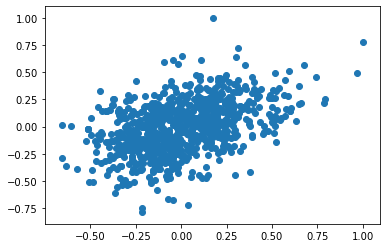

In [155]:
plt.scatter(dev_norm[:,1],dev_norm[:,2])

In [38]:
np.max(dev_centered, axis = 0).shape

(10,)

In [23]:
train_labels = train_marginals.copy()
train_labels[train_labels > .5] = 1
train_labels[train_labels <= .5] = 0

In [157]:
gpc_dev.fit(dev_norm, dev_labels.reshape(920,))

GaussianProcessClassifier(copy_X_train=True,
                          kernel=RBF(length_scale=1) + WhiteKernel(noise_level=1),
                          max_iter_predict=100, multi_class='one_vs_rest',
                          n_jobs=None, n_restarts_optimizer=0,
                          optimizer='fmin_l_bfgs_b', random_state=None,
                          warm_start=False)

In [158]:
gpc_dev.kernel_

RBF(length_scale=1.15) + WhiteKernel(noise_level=1e-05)

In [41]:
gpc_train.fit(train_norm, train_labels.reshape(8433,))

GaussianProcessClassifier(copy_X_train=True,
                          kernel=RBF(length_scale=1) + WhiteKernel(noise_level=1),
                          max_iter_predict=100, multi_class='one_vs_rest',
                          n_jobs=None, n_restarts_optimizer=0,
                          optimizer='fmin_l_bfgs_b', random_state=None,
                          warm_start=False)

In [159]:
gpc_train.kernel_

AttributeError: 'GaussianProcessClassifier' object has no attribute 'n_classes_'

In [43]:
test_features = lstm.feature_outputs(test,100)

In [44]:
gpc_train.kernel_

RBF(length_scale=1.29) + WhiteKernel(noise_level=1e-05)

In [160]:
ud = []
ut = []
preds_d = gpc_dev.predict_proba(test_features.detach().numpy().reshape(4683,10), uncertainty = ud)
#preds_t = gpc_train.predict_proba(test_features.detach().numpy().reshape(4683,10), uncertainty = ut)

In [161]:
ud = ud[0]
#ut = ut[0]

In [145]:
gpc_dev.classes_

array([0, 1], dtype=int64)

In [165]:
ud

1.0000100000000001

In [162]:
preds_d

array([[ 0.49999954,  0.50000046],
       [ 0.49825962,  0.50174038],
       [ 0.59181157,  0.40818843],
       ..., 
       [ 0.49734277,  0.50265723],
       [ 0.44500853,  0.55499147],
       [ 0.45615477,  0.54384523]])

In [147]:
lstm.marginals(test)

/home/cperreault/anaconda3/envs/snorkel-extraction/lib/python3.6/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


array([ 0.72838098,  0.67866069,  0.46372822, ...,  0.6755054 ,
        0.63941175,  0.63752621], dtype=float32)

In [148]:
test_y

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

In [166]:
# what is the order of the probabilties? I think I was probably doingit backwards actually. 
pd, pt = [],[]
for x in preds_d:
    if x[0] > .5:
        pd.append(0)
    else:
        pd.append(1)
for x in preds_t:
    if x[0] > .5:
        pt.append(0)
    else:
        pt.append(1) 

In [167]:
ud = np.array(ud)
ut = np.array(ut)

In [151]:
ud.mean()

0.24177084421181586

In [152]:
ud.max()

0.94028378290305437

In [140]:
ut.mean()

/home/cperreault/anaconda3/envs/snorkel-extraction/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice.
  """Entry point for launching an IPython kernel.
/home/cperreault/anaconda3/envs/snorkel-extraction/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan

In [141]:
ut.max()

ValueError: zero-size array to reduction operation maximum which has no identity

In [115]:
test_y = L_gold_test.toarray().reshape(4683,)
test_y[test_y == -1] = 0

In [116]:
buckets = np.linspace(0,1,15)

In [170]:
sum(1 for x in test_y if x == 1)

1514

In [172]:
pre = gpc_dev.predict(test_features.detach().numpy().reshape(4683,10))

In [178]:
acc = []
for i in range(14):
    cor, inc = 0,0
    count  =0
    for j,p in enumerate(test_y):
        if ud[j] >= buckets[i] and ud[j] < buckets[i+1]:
            count += 1
            if p == pre[j]:
                cor += 1
    if count > 0:
        acc.append(cor/count)
    else:
        acc.append(0)
                

<BarContainer object of 14 artists>

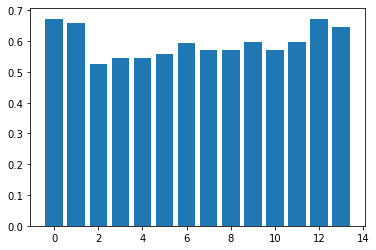

In [180]:
plt.bar(np.arange(14),acc)

In [184]:
f1scores = []
tpfp = []
tnfn = []
for i in range(14):
    count = 0
    tp,fp,tn,fn = 0,0,0,0
    for j,p in enumerate(test_y):
        if ud[j] >= buckets[i] and ud[j] < buckets[i+1]:
            count += 1
            if p == 0 and pd[j] == 0:
                tn += 1
            elif p == 0 and pd[j] == 1:
                fp += 1
            elif p == 1 and pd[j] == 0:
                fn += 1
            else: #p == 1 and preds[j] == 1:
                tp += 1
    try:
        p = tp / (tp + fp)
    except:
        p = 0
    try:
        r = tp / (tp + fn)
    except: 
        r = 0
    try:
        f1 = 2/(1/p + 1/r)
    except:
        f1 = 0
    f1scores.append(f1)
    tpfp.append(tp/(tp +fp))
    tnfn.append(tn/(tn +fn))
    print ("Bucket {}: \n Count: {}\n F1: {}\n{},{},{},{}".format(buckets[i+1], count, f1,tp,fp,tn,fn))

Bucket 0.07142857142857142: 
 Count: 116
 F1: 0
0,2,78,36
Bucket 0.14285714285714285: 
 Count: 391
 F1: 0.1625
13,35,244,99
Bucket 0.21428571428571427: 
 Count: 242
 F1: 0.14814814814814814
10,52,117,63
Bucket 0.2857142857142857: 
 Count: 171
 F1: 0.2040816326530612
10,49,83,29
Bucket 0.3571428571428571: 
 Count: 158
 F1: 0.28
14,45,72,27
Bucket 0.42857142857142855: 
 Count: 118
 F1: 0.42222222222222217
19,36,47,16
Bucket 0.5: 
 Count: 108
 F1: 0.4054054054054054
15,30,49,14
Bucket 0.5714285714285714: 
 Count: 107
 F1: 0.41025641025641024
16,25,45,21
Bucket 0.6428571428571428: 
 Count: 105
 F1: 0.3283582089552239
11,26,49,19
Bucket 0.7142857142857142: 
 Count: 122
 F1: 0.3466666666666666
13,33,60,16
Bucket 0.7857142857142857: 
 Count: 126
 F1: 0.4375
21,35,51,19
Bucket 0.8571428571428571: 
 Count: 173
 F1: 0.46153846153846156
30,47,73,23
Bucket 0.9285714285714285: 
 Count: 252
 F1: 0.5310734463276836
47,58,122,25
Bucket 1.0: 
 Count: 1452
 F1: 0.5291970802919708
290,379,646,137


<BarContainer object of 14 artists>

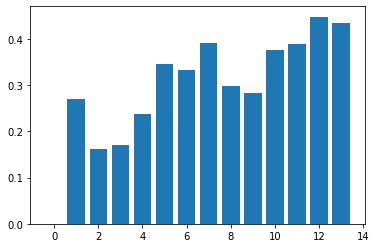

In [185]:
plt.bar(np.arange(14),tpfp)

<BarContainer object of 14 artists>

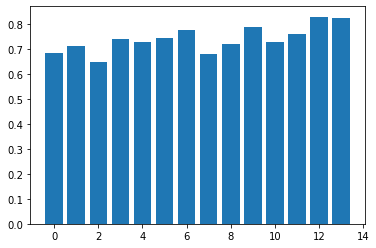

In [186]:
plt.bar(np.arange(14),tnfn)

<BarContainer object of 14 artists>

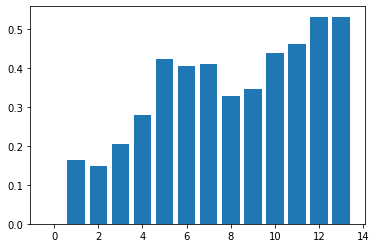

In [169]:
plt.bar(np.arange(len(f1scores)),f1scores)

In [119]:
f1scores = []
for i in range(14):
    count = 0
    tp,fp,tn,fn = 0,0,0,0
    for j,p in enumerate(test_y):
        if ut[j] >= buckets[i] and ut[j] < buckets[i+1]:
            count += 1
            if p == 0 and pt[j] == 0:
                tn += 1
            elif p == 0 and pt[j] == 1:
                fp += 1
            elif p == 1 and pt[j] == 0:
                fn += 1
            else: #p == 1 and preds[j] == 1:
                tp += 1
    try:
        p = tp / (tp + fp)
    except:
        p = 0
    try:
        r = tp / (tp + fn)
    except: 
        r = 0
    try:
        f1 = 2/(1/p + 1/r)
    except:
        f1 = 0
    f1scores.append(f1)
    print ("Bucket {}: \n Count: {}\n F1: {}\n{},{},{},{}".format(buckets[i+1], count, f1,tp,fp,tn,fn))

Bucket 0.07142857142857142: 
 Count: 561
 F1: 0.3855421686746988
96,239,159,67
Bucket 0.14285714285714285: 
 Count: 364
 F1: 0.40282685512367494
57,128,138,41
Bucket 0.21428571428571427: 
 Count: 213
 F1: 0.2556390977443609
17,63,97,36
Bucket 0.2857142857142857: 
 Count: 155
 F1: 0.4482758620689655
26,42,65,22
Bucket 0.3571428571428571: 
 Count: 134
 F1: 0.38383838383838387
19,37,54,24
Bucket 0.42857142857142855: 
 Count: 130
 F1: 0.37499999999999994
15,30,65,20
Bucket 0.5: 
 Count: 107
 F1: 0.24615384615384617
8,32,50,17
Bucket 0.5714285714285714: 
 Count: 100
 F1: 0.4383561643835616
16,27,43,14
Bucket 0.6428571428571428: 
 Count: 109
 F1: 0.42105263157894735
16,28,49,16
Bucket 0.7142857142857142: 
 Count: 141
 F1: 0.49504950495049505
25,34,65,17
Bucket 0.7857142857142857: 
 Count: 148
 F1: 0.568421052631579
27,29,80,12
Bucket 0.8571428571428571: 
 Count: 185
 F1: 0.5205479452054794
38,54,77,16
Bucket 0.9285714285714285: 
 Count: 243
 F1: 0.47619047619047616
40,70,115,18
Bucket 1.0: 


<BarContainer object of 14 artists>

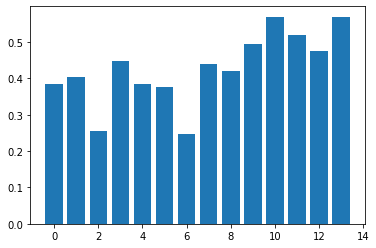

In [120]:
plt.bar(np.arange(len(f1scores)),f1scores)

In [123]:
tp,fp,tn,fn = 0,0,0,0
for j,p in enumerate (test_y):
        if p == 0 and pt[j] == 0:
            tn += 1
        elif p == 0 and pt[j] == 1:
            fp += 1
        elif p == 1 and pt[j] == 0:
            fn += 1
        else: #p == 1 and preds[j] == 1:
            tp += 1
try:
    p = tp / (tp + fp)
except:
    p = 0
try:
    r = tp / (tp + fn)
except: 
    r = 0
try:
    f1 = 2/(1/p + 1/r)
except:
    f1 = 0

In [124]:
f1

0.5325720218011939

In [103]:
p

0.20819112627986347

In [104]:
dev_cov= np.matmul(dev_features.detach().numpy().reshape(920,10).transpose(), dev_features.detach().numpy().reshape(920,10))

AttributeError: 'numpy.ndarray' object has no attribute 'detach'

In [105]:
np.linalg.svd(dev_cov)

(array([[ -1.75624362e-02,  -5.07831935e-01,   4.76890351e-01,
          -4.52880033e-01,  -2.50661105e-01,   1.92713573e-01,
          -3.87244354e-01,  -2.43594895e-01,   2.70553847e-03,
           2.48650847e-04],
        [  1.39541445e-02,  -3.80187015e-01,  -6.86840118e-01,
          -2.31602724e-01,   2.85723805e-01,  -2.15405557e-01,
          -4.18618747e-01,   7.91484016e-02,   3.79902102e-02,
           1.37429684e-01],
        [  1.08962639e-02,  -1.06213725e-01,  -1.67330246e-01,
          -8.71600972e-02,   8.47431516e-02,  -8.24925681e-02,
           2.42685386e-01,  -4.91430492e-01,  -7.11025771e-01,
          -3.64773114e-01],
        [ -9.53384556e-03,   1.27960265e-01,   9.86448365e-02,
           9.51896011e-02,   1.39126252e-01,   2.35602634e-01,
          -4.64984909e-01,   5.28507116e-01,  -3.08186997e-01,
          -5.47145990e-01],
        [  4.55275794e-02,   1.26058109e-01,  -4.94351729e-02,
           5.55763049e-01,  -7.67240175e-02,   2.65446791e-01,
      

In [106]:
gpc_d.score(test_features, test_y)

NameError: name 'gpc_d' is not defined